## Read time series data and split

In [2]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import pickle

In [3]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
#df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
#df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 1024
* fixed size bins

Future:
* discretize each column individually
* quantile-based bins (centered at 0)

In [4]:
# Z-norm standardisation
#X['Power demand'] = np.log1p(X['Power demand'])
mu = X.mean(axis=0)
sigma = X.std(axis=0) + 1e-8

X_normalized = (X-mu)/sigma
X_normalized = X_normalized.diff().dropna()
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [5]:
# fit bins
n_bins=1024

#edges, mids = discretize.fit_quantile_bins_global(X_nv, n_bins=n_bins)
edges, mids = discretize.fit_equal_width_bins_global(X_nv, n_bins=n_bins)

# encode
#X_tok = discretize.encode_quantile_global(jnp.asarray(X_nv), edges)
X_tok = discretize.encode_equal_width_global(jnp.asarray(X_nv), edges)

# decode
#X_rec = discretize.decode_quantile_global(X_tok, mids)
X_rec = discretize.decode_equal_width_global(X_tok, mids)

ZERO_BIN = int(np.argmin(np.abs(mids)))
#or
assert(ZERO_BIN == discretize.encode_equal_width_global(jnp.asarray([0]), edges))

print("Zero midpoint:", mids[ZERO_BIN])
print("Index:", ZERO_BIN)


Zero midpoint: -0.0015580654
Index: 514


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

In [6]:
n_channels = len(X.columns)
#tokens = tokenizer.encode_with_channels(X_tok, n_channels)
tokens = tokenizer.encode_with_channels_sparse(X_tok, n_channels, ZERO_BIN)

DATA_OFFSET = 2 + n_channels  # BOS+EOS+n_channels = 9
vocab_size = DATA_OFFSET + n_bins

In [7]:
T = tokens.shape[0]
print("Total tokens:", T)
print("Vocab size:", vocab_size)

# Inspect first few tokens
print("Last 100 tokens:", tokens[:100])

Total tokens: 373770
Vocab size: 1033
Last 100 tokens: [  0   2 509   1   0   2 512   3 517   4 514   5 519   8 539   1   0   2
 518   3 517   4 524   5 538   1   0   2 529   3 517   4 526   5 542   8
 507   1   0   2 549   3 508   4 497   5 504   8 541   1   0   2 578   3
 517   4 509   5 508   8 531   1   0   2 596   3 526   4 528   5 527   8
 520   1   0   2 580   3 524   4 525   5 525   8 550   1   0   2 558   3
 536   4 530   5 510   8 531   1   0   2]


# Training

In [8]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from jax import value_and_grad, random, lax
import pickle
import pandas as pd
import math
from functools import partial

from helper_funcs import generate, masked_fill
from tqdm import tqdm
import matplotlib.pyplot as plt
from attention_model import *
print(jax.devices())

[CpuDevice(id=0)]


In [10]:
n_embed = 16 # 32 # Number of embedding dimensions
batch_size = 8 #4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization
learning_rate = 1e-5

rng_key = jax.random.PRNGKey(42)

In [11]:
rng_key, subkey = jax.random.split(rng_key)
xb, yb = tokenizer.get_token_batch(tokens, subkey, batch_size, n_channels, block_size)
token_types = tokenizer.compute_token_types(xb, n_channels)

## Build the Attention Model

In [135]:
model = GPT2_v3(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate, n_channels)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
dummy_token_types = jnp.zeros_like(dummy_x)
dummy_channel_ids = jnp.zeros_like(dummy_x)
variables = model.init(rng_key, dummy_x, dummy_token_types, dummy_channel_ids)

In [136]:
out = model.apply(variables, dummy_x, dummy_token_types, dummy_channel_ids)
print(out.shape)

(8, 480, 1033)


## Train the Model

In [137]:
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate)
)
opt_state = optimizer.init(variables)
losses = []

**Cross-entropy intuition**

For a model that is basically guessing, the expected loss is:

$$loss≈log⁡(vocab size)$$

More epochs will just produce more samples of the same noise band.

In [138]:
np.log(vocab_size)

np.float64(6.940222469119639)

In [ ]:
epochs = 500000
train_tokens = tokens

pbar = tqdm(range(epochs))
for epoch in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = tokenizer.get_token_batch(train_tokens, subkey, batch_size, n_channels, block_size)
    token_types = tokenizer.compute_token_types(xb, n_channels)
    channel_ids = tokenizer.compute_channel_ids(xb, n_channels)

    loss, grads = value_and_grad(tokenizer.loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        token_types,
        channel_ids,
        n_channels,
        yb
    )

    if math.isnan(loss):
        print(f"Premature stop (loss=nan) at epoch {epoch}")
        break

    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {epoch}, Loss: {loss :.4f}")

In [ ]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": epoch,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
    "n_channels": n_channels,
    "n_bins": n_bins,
    "edges": edges, 
    "mids": mids,
    "mu": mu,
    "sigma": sigma,
}

with open('models/token_model.pkl', 'wb') as f:
    pickle.dump(model_file, f)

In [9]:
# Load model
with open('models/token_model.pkl', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

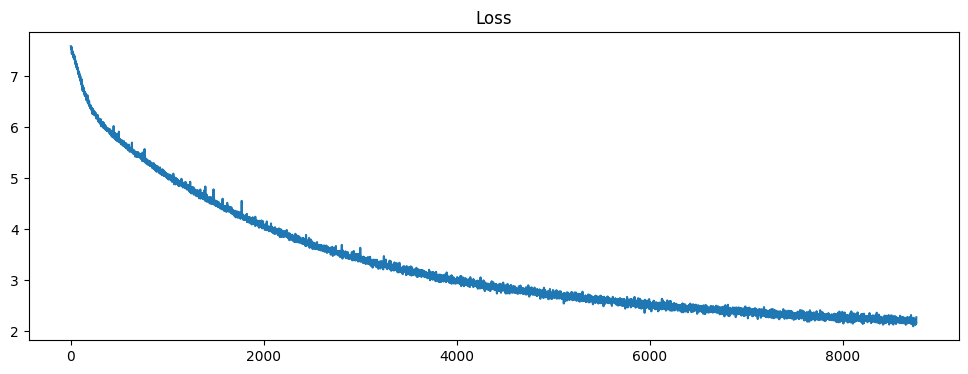

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [11]:
def infer_token_types_and_channels(tokens, n_channels):
    """
    tokens: (B, T)
    returns:
        token_types: (B, T)
        channel_ids: (B, T)
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    # token type ids
    token_types = jnp.where(
        tokens == BOS, 0,
        jnp.where(
            tokens == EOS, 1,
            jnp.where(
                tokens < DATA_OFFSET, 2,  # CH
                3                           # DATA
            )
        )
    )

    # channel ids
    channel_ids = jnp.where(
        (tokens >= CH_OFFSET) & (tokens < DATA_OFFSET),
        tokens - CH_OFFSET,
        0
    )

    return token_types, channel_ids

def token_type(tok, n_channels):
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    return jnp.where(
        tok == BOS, 0,
        jnp.where(
            tok == EOS, 1,
            jnp.where(
                tok < DATA_OFFSET, 2,  # CH
                3                       # DATA
            )
        )
    )

def grammar_mask(last_tok, n_channels, vocab_size):
    """
    Returns mask: True = allowed, False = forbidden
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    ttype = token_type(last_tok, n_channels)

    allowed = jnp.zeros((vocab_size,), dtype=jnp.bool_)

    def allow(mask, lo, hi):
        return mask.at[lo:hi].set(True)

    # BOS → CH or EOS
    allowed = jax.lax.cond(
        ttype == 0,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # CH → DATA
    allowed = jax.lax.cond(
        ttype == 2,
        lambda m: allow(m, DATA_OFFSET, vocab_size),
        lambda m: m,
        allowed
    )

    # DATA → CH or EOS
    allowed = jax.lax.cond(
        ttype == 3,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # EOS → EOS only
    allowed = jax.lax.cond(
        ttype == 1,
        lambda m: m.at[EOS].set(True),
        lambda m: m,
        allowed
    )

    return allowed

@partial(
    jax.jit,
    static_argnames=[
        'forward_fn',
        'vocab_size',
        'block_size',
        'max_new_tokens',
        'n_channels',
    ],
)
def generate_sparse(
    variables,
    forward_fn,
    index_seq,     # (T,)
    rng_key,
    vocab_size,
    block_size,
    max_new_tokens,
    n_channels,
    EOS=1,
):
    # -----------------------------
    # constants
    # -----------------------------
    BOS = 0
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    index_seq = jnp.asarray(index_seq)
    T = index_seq.shape[0]
    B = 1

    total_len = block_size + T + max_new_tokens

    # output buffer
    out = jnp.zeros((B, total_len), dtype=index_seq.dtype)

    # write initial tokens after padding
    out = lax.dynamic_update_slice(
        out,
        index_seq[None, :],
        (0, block_size),
    )

    write_pos = block_size + T

    finished = jnp.zeros((B,), dtype=jnp.bool_)
    emitted_any = jnp.zeros((B,), dtype=jnp.bool_)

    # -----------------------------
    # scan step
    # -----------------------------
    def step(carry, _):
        out, rng, write_pos, finished, emitted_any = carry

        # ---- context window ----
        start = jnp.maximum(write_pos - block_size, 0)
        ctx = lax.dynamic_slice(out, (0, start), (B, block_size))

        token_types, channel_ids = infer_token_types_and_channels(
            ctx, n_channels
        )

        logits = forward_fn(
            variables,
            ctx,
            token_types,
            channel_ids,
        )
        logits = logits[:, -1]  # (B, vocab)

        last_tok = ctx[:, -1]   # (B,)

        # -----------------------------
        # grammar mask (CORRECT)
        # -----------------------------
        mask = jnp.zeros((vocab_size,), dtype=jnp.bool_)

        is_bos = last_tok[0] == BOS
        is_ch  = (last_tok[0] >= CH_OFFSET) & (last_tok[0] < DATA_OFFSET)
        is_data = last_tok[0] >= DATA_OFFSET

        def bos_case(m):
            return m.at[CH_OFFSET:DATA_OFFSET].set(True)

        def ch_case(m):
            return m.at[DATA_OFFSET:].set(True)

        def data_case(m):
            m = m.at[CH_OFFSET:DATA_OFFSET].set(True)
            m = m.at[EOS].set(emitted_any[0])
            return m

        mask = jax.lax.cond(
            is_bos,
            bos_case,
            lambda m: jax.lax.cond(
                is_ch,
                ch_case,
                data_case,
                m
            ),
            mask
        )

        # -----------------------------
        # sampling
        # -----------------------------
        rng, sub = jax.random.split(rng)

        temperature = 1.0
        masked_logits = jnp.where(mask, logits / temperature, -1e9)

        next_tok = jax.random.categorical(sub, masked_logits)

        # force EOS if already finished
        next_tok = jnp.where(finished, EOS, next_tok)

        # -----------------------------
        # update state
        # -----------------------------
        out = lax.dynamic_update_slice(
            out,
            next_tok[:, None],
            (0, write_pos),
        )

        is_data_tok = next_tok >= DATA_OFFSET
        emitted_any = emitted_any | is_data_tok

        # reset emitted_any on BOS (row boundary)
        emitted_any = jax.lax.select(
            next_tok == BOS,
            jnp.zeros_like(emitted_any),
            emitted_any,
        )

        finished = jnp.logical_or(finished, next_tok == EOS)
        write_pos = write_pos + 1

        return (out, rng, write_pos, finished, emitted_any), None

    # -----------------------------
    # run scan
    # -----------------------------
    (out, _, write_pos, _, _), _ = lax.scan(
        step,
        (out, rng_key, write_pos, finished, emitted_any),
        None,
        length=max_new_tokens,
    )

    # return flat buffer and write position
    return out[0], write_pos

## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [12]:
rng_key = jax.random.PRNGKey(128)

In [13]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens]#.reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 5734
Context window: 480
Last context tokens: [  0   2 526   3 522   4 522   6 476   7 451   8 518   1   0   2 498   1
   0   2 501   3 524   4 525   8 528   1   0   2 504   3 519   4 525   5
 532   8 510   1   0   2 504   3 517   5 534   8 516   1   0   2 506   3
 527   4 529   5 525   6 575   7 595   8 529   1   0   2 507   3 521   4
 527   5 534   6 556   7 595   8 516   1   0   2 507   3 504   4 516   5
 547   6 603   7 609   8 531   1   0   2 514   3 513   4 520   5 536   6
 580   7 540   8 530   1   0   2 520   6 476   7 455   8 517   1   0   2
 552   6 551   7 485   8 531   1   0   2 570   3 530   4 522   5 510   6
 551   7 540   8 529   1   0   2 544   3 536   4 526   5 504   7 561   8
 514   1   0   2 529   3 530   4 530   6 551   7 540   8 516   1   0   2
 510   4 527   5 530   6 547   7 540   8 525   1   0   2 533   3 526   4
 526   6 533   7 472   8 511   1   0   2 526   4 531   5 536   6 533   7
 489   8 516   1   0   2 514   3 521   4 528   5 536   6 514

In [14]:
def token_type(tok, n_channels):
    BOS = 0
    EOS = 1
    DATA_OFFSET = 2 + n_channels

    return jnp.where(
        tok == BOS, 0,
        jnp.where(
            tok == EOS, 1,
            jnp.where(tok < DATA_OFFSET, 2, 3)
        )
    )

def grammar_mask_from_last(
    last_tok,
    emitted_any,
    vocab_size,
    n_channels,
):
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    ttype = token_type(last_tok, n_channels)
    mask = jnp.zeros((vocab_size,), dtype=jnp.bool_)

    def bos_case(m):
        return m.at[CH_OFFSET:DATA_OFFSET].set(True)

    def ch_case(m):
        return m.at[DATA_OFFSET:].set(True)

    def data_case(m):
        m = m.at[CH_OFFSET:DATA_OFFSET].set(True)
        m = m.at[EOS].set(emitted_any)
        return m

    def eos_case(m):
        return m.at[BOS].set(True)

    return lax.switch(
        ttype,
        [bos_case, eos_case, ch_case, data_case],
        mask,
    )

def emitted_any_from_stream(stream, n_channels):
    BOS = 0
    DATA_OFFSET = 2 + n_channels

    T = stream.shape[0]
    idx = jnp.arange(T)

    # index of last BOS
    is_bos = stream == BOS
    last_bos = jnp.max(jnp.where(is_bos, idx, -1))

    # DATA tokens strictly after last BOS
    is_data_after = (stream >= DATA_OFFSET) & (idx > last_bos)

    return jnp.any(is_data_after)

@partial(
    jax.jit,
    static_argnames=[
        'forward_fn',
        'vocab_size',
        'block_size',
        'max_new_tokens',
        'n_channels',
    ],
)
def generate_continue(
    variables,
    forward_fn,
    token_stream,     # (T,)
    rng_key,
    vocab_size,
    block_size,
    max_new_tokens,
    n_channels,
    BOS = 0,
    EOS=1,
):
    token_stream = jnp.asarray(token_stream)

    # infer emitted_any from history
    DATA_OFFSET = 2 + n_channels
    emitted_any = emitted_any_from_stream(token_stream, n_channels)

    def step(carry, _):
        ctx, rng, emitted_any = carry
        ctx_batched = ctx[None, :]  # (1, T)

        token_types, channel_ids = infer_token_types_and_channels(
            ctx_batched, n_channels # was ctx
        )

        logits = forward_fn(
            variables,
            ctx_batched, #ctx,
            token_types,
            channel_ids,
        )[:, -1]  # (1, vocab)

        last_tok = ctx[-1] #ctx[0, -1]

        mask = grammar_mask_from_last(
            last_tok,
            emitted_any,
            vocab_size,
            n_channels,
        )

        rng, sub = jax.random.split(rng)
        masked_logits = jnp.where(mask, logits, -1e9)
        next_tok = jax.random.categorical(sub, masked_logits)[0]

        # update emitted_any
        is_data = next_tok >= DATA_OFFSET
        emitted_any = lax.select(
            next_tok == BOS, 
            False, 
            emitted_any | is_data
        )

        # roll context left and append next token
        ctx = jnp.concatenate([ctx[1:], jnp.array([next_tok])], axis=0)
        return (ctx, rng, emitted_any), next_tok

    # pad on the left if token_stream is shorter than block_size
    pad = jnp.zeros((max(0, block_size - token_stream.shape[0]),), dtype=token_stream.dtype)
    ctx0 = jnp.concatenate([pad, token_stream[-block_size:]], axis=0)

    (_, _, _), new_tokens = lax.scan(
        step,
        (ctx0, rng_key, emitted_any),
        None,
        length=max_new_tokens,
    )

    return new_tokens

rng_key, subkey = jax.random.split(rng_key)

new_tokens = generate_continue(
    variables,
    model.apply,
    token_stream=token_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [15]:
def decode_with_channels_stream(flat, n_channels):
    """
    Decode a flat token stream into completed frames.

    Rules:
    - Frames start at BOS (0)
    - Frames end at EOS (1)
    - CH tokens select channel
    - DATA tokens assign value to last CH
    - Unfinished trailing frames are skipped

    Returns:
        (N, n_channels) array
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    flat = jnp.asarray(flat)

    rows = []
    i = 0
    L = flat.shape[0]

    while i < L:
        # wait for BOS
        if flat[i] != BOS:
            i += 1
            continue

        i += 1  # consume BOS
        row = jnp.zeros((n_channels,), dtype=flat.dtype)
        seen = jnp.zeros((n_channels,), dtype=bool)
        current_ch = -1

        while i < L and flat[i] != EOS:
            tok = flat[i]

            # channel token
            if CH_OFFSET <= tok < DATA_OFFSET:
                current_ch = tok - CH_OFFSET

            # data token
            elif tok >= DATA_OFFSET and current_ch >= 0:
                row = row.at[current_ch].set(tok - DATA_OFFSET)
                seen = seen.at[current_ch].set(True)

            i += 1

        # emit only if EOS found and at least one channel seen
        if i < L and flat[i] == EOS and jnp.any(seen):
            rows.append(row)

        i += 1  # consume EOS

    if len(rows) == 0:
        return jnp.empty((0, n_channels), dtype=flat.dtype)

    return jnp.stack(rows, axis=0)

In [16]:
new_Y_tok = decode_with_channels_stream(new_tokens, n_channels)
new_Y_tok

Array([[197, 510,   0,   0,   0,   0,   0],
       [512, 507, 527, 533, 534,   0, 521],
       [501, 501,   0,   0,   0,   0, 531],
       [505, 508,   0,   0,   0,   0,   0],
       [507, 491,   0, 510, 520,   0,   0],
       [518, 482, 504,   0,   0,   0, 510],
       [516, 512, 524,   0, 515,   0,   0],
       [501, 536, 516,   0,   0,   0, 528],
       [  0, 507,   0,   0,   0,   0,   0],
       [503, 521,   0,   0,   0,   0,   0],
       [  0, 429,   0,   0,   0,   0,   0],
       [  0, 516,   0,   0,   0,   0, 525],
       [  0, 504, 533,   0,   0,   0,   0],
       [489, 748, 510,   0, 500,   0, 425],
       [  0, 672,   0,   0,   0,   0,   0],
       [  0, 522,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 502],
       [508,   0,   0,   0,   0,   0,   0],
       [  0, 646, 304, 528,   0,   0, 667],
       [531,   0,   0,   0,   0,   0,   0],
       [  0, 582, 536,   0,   0,   0,   0],
       [  0, 552,   0, 552, 519,   0, 498],
       [  0, 802,   0,   0, 521,

In [17]:
def decode_equal_width_global(tokens, mids):
    """
    Global equal-width decoding.

    tokens: (T, D)
    mids:   (n_bins,)
    returns: (T, D) approx continuous values
    """
    mids = jnp.asarray(mids)
    tokens = jnp.asarray(tokens)

    tokens_clipped = jnp.clip(tokens, 0, mids.shape[0] - 1)
    values = mids[tokens_clipped]

    return jnp.where(tokens == 0, 0.0, values) # jnp.nan

Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

In [19]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = decode_equal_width_global(new_Y_tok, mids)
Y_rec = pd.DataFrame(Y_rec, columns=X_test_normalized.columns)
Y_rec = Y_rec * sigma # delta model so mu is not added back

init_values = X_test.iloc[-1].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=X_test_normalized.columns, index=Y_test.index)
Y_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-07-28 11:00:00,825.878418,26.672628,27.000000,100.000000,275.000000,9.400000,999.000000
2021-07-28 12:00:00,799.916260,26.109211,27.898996,104.429405,296.083557,9.400000,999.457275
2021-07-28 13:00:00,641.784424,25.073704,27.898996,104.429405,296.083557,9.400000,1000.583191
2021-07-28 14:00:00,531.714355,24.588968,27.898996,104.429405,296.083557,9.400000,1000.583191
2021-07-28 15:00:00,445.675293,22.766645,27.898996,103.451157,302.289093,9.400000,1000.583191
2021-07-28 16:00:00,491.805664,20.236187,27.187550,103.451157,302.289093,9.400000,1000.304993
2021-07-28 17:00:00,513.905273,20.066177,27.876488,103.451157,303.181000,9.400000,1000.304993
2021-07-28 18:00:00,355.773926,21.784527,28.005272,103.451157,303.181000,9.400000,1001.230286
2021-07-28 19:00:00,355.773926,21.221109,28.005272,103.451157,303.181000,9.400000,1001.230286


In [20]:
Y_test

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-07-28 11:00:00,4666.079167,26.60,26.45,99.0,290.0,11.20,998.90
2021-07-28 12:00:00,4630.165833,26.10,25.95,99.0,285.0,12.10,998.90
2021-07-28 13:00:00,4435.429167,26.00,26.00,100.0,275.0,10.30,998.50
2021-07-28 14:00:00,4506.218333,26.00,25.75,98.5,270.0,9.40,997.75
2021-07-28 15:00:00,4495.006667,26.00,25.75,98.5,265.0,8.50,997.25
2021-07-28 16:00:00,4434.110000,26.00,26.00,100.0,265.0,8.50,997.00
2021-07-28 17:00:00,4395.293333,26.10,25.95,99.0,270.0,8.50,996.65
2021-07-28 18:00:00,4268.305000,26.60,25.95,96.0,260.0,7.60,996.65
2021-07-28 19:00:00,4239.759167,26.50,26.00,97.0,240.0,7.60,997.50


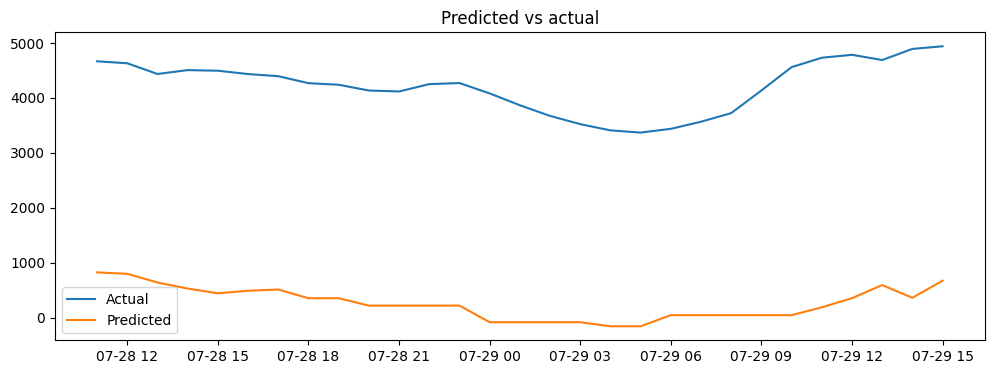

In [21]:
col = 'Power demand'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_pred.index, Y_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [34]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[0]] = False
mask[4:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_equal_width_global(jnp.asarray(X_masked_nv), edges)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, ZERO_BIN)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

Number of tokens: 3622
Context window: 480
Last context tokens: [  0   3 519   4 535   5 530   1   0   3 500   4 583   5 572   1   0   3
 498   4 554   5 555   1   0   3 502   4 496   5 519   1   0   3 513   4
 550   5 555   1   0   4 531   5 530   1   0   3 527   4 512   5 508   1
   0   4 518   5 519   1   0   4 515   5 517   1   0   3 542   4 516   5
 504   1   0   3 538   4 509   5 502   1   0   3 549   4 510   5 502   1
   0   3 565   4 502   5 493   1   0   3 564   4 492   5 500   1   0   3
 549   4 485   5 506   1   0   3 533   4 513   5 519   1   0   3 535   4
 522   5 521   1   0   3 530   4 507   5 519   1   0   3 524   4 513   5
 521   1   0   3 514   4 537   5 527   1   0   3 504   4 538   5 530   1
   0   3 494   4 552   5 538   1   0   3 484   4 602   5 570   1   0   3
 491   4 550   5 549   1   0   3 512   4 498   5 515   1   0   3 514   4
 565   5 559   1   0   3 517   4 525   5 527   1   0   3 519   4 482   5
 496   1   0   3 512   4 566   5 566   1   0   3 510   5 532

In [35]:
X_masked

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-04-09 12:00:00,0.0,0.184805,-0.221513,-0.082460,0.0,0.0,0.0
2021-04-09 13:00:00,0.0,0.024641,-0.706072,-0.185536,0.0,0.0,0.0
2021-04-09 14:00:00,0.0,0.098563,0.546859,0.103075,0.0,0.0,0.0
2021-04-09 15:00:00,0.0,0.061602,0.055378,0.000000,0.0,0.0,0.0
2021-04-09 16:00:00,0.0,-0.098563,-0.546859,-0.103075,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-04-29 06:00:00,0.0,-0.061602,0.117679,0.123690,0.0,0.0,0.0
2021-04-29 07:00:00,0.0,0.049281,-0.006922,-0.041230,0.0,0.0,0.0
2021-04-29 08:00:00,0.0,0.209446,-0.103834,-0.206151,0.0,0.0,0.0


In [36]:
new_masked_tokens = generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [37]:
# Decode from sparse to all channels
new_masked_tok = decode_with_channels_stream(new_masked_tokens, n_channels)

In [38]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = decode_equal_width_global(new_masked_tok, mids)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)


,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,-218.208767,-0.327372,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,-6.936628,0.000000,0.000000,0.000000,0.0,15.634892
2,-2260.831159,-0.563417,0.898996,4.429408,21.083563,0.0,0.457287
3,-158.131799,-1.743642,0.000000,0.000000,0.000000,0.0,13.762765
4,-110.069987,-0.484735,0.128785,0.000000,0.000000,0.0,0.000000
5,2052.706489,-2.530458,0.000000,-0.978247,6.205519,0.0,-0.278192
6,0.000000,1.718349,0.128785,0.000000,0.891913,0.0,0.925318
7,-86.039082,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,-134.100893,-1.114187,0.000000,0.000000,0.000000,0.0,0.000000
9,-4207.329929,-6.700583,0.000000,0.000000,0.000000,0.0,0.000000


In [39]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-04-29 11:00:00,2897.329590,34.172630,8.950000,21.000000,290.000000,9.4,1010.500000
2021-04-29 12:00:00,2897.329590,27.236000,8.950000,21.000000,290.000000,9.4,1026.134888
2021-04-29 13:00:00,636.498535,26.672583,9.848996,25.429407,311.083557,9.4,1026.592163
2021-04-29 14:00:00,478.366699,24.928942,9.848996,25.429407,311.083557,9.4,1040.354980
2021-04-29 15:00:00,368.296631,24.444206,9.977780,25.429407,311.083557,9.4,1040.354980
2021-04-29 16:00:00,2421.003418,21.913750,9.977780,24.451160,317.289093,9.4,1040.076782
2021-04-29 17:00:00,2421.003418,23.632099,10.106565,24.451160,318.181000,9.4,1041.002075
2021-04-29 18:00:00,2334.964355,23.632099,10.106565,24.451160,318.181000,9.4,1041.002075
2021-04-29 19:00:00,2200.863281,22.517910,10.106565,24.451160,318.181000,9.4,1041.002075


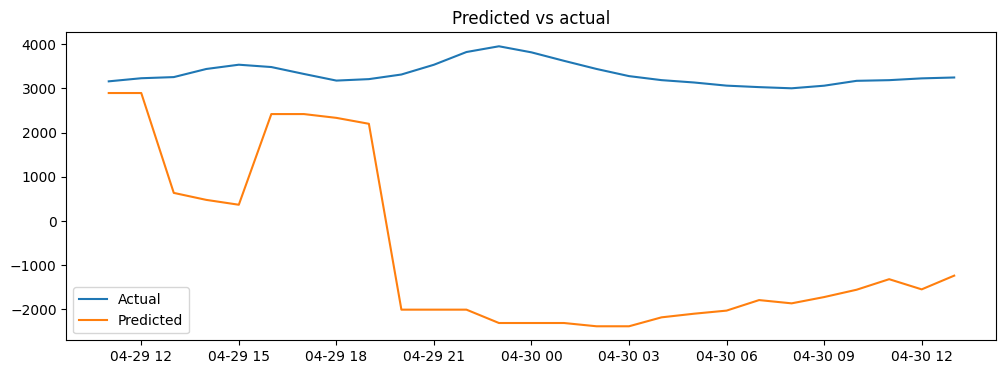

In [40]:
col = 'Power demand'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()